In [52]:
#packages
import pandas as pd
import numpy as np
import os
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [53]:
crypto_tickers = [
    "ADA", "AVAX", "BCH", "BNB", "BTC", "DOGE", "DOT",
    "ETH", "LEO", "LINK", "LTC", "NEAR", "SHIB", "SOL",
    "TON", "TRX", "UNI", "XRP",
]

equity_tickers = ["SPY"]

sector_tickers = [
    "XLB", "XLE", "XLF", "XLI", "XLK",
    "XLP", "XLRE", "XLU", "XLV", "XLY",
]

all_tickers = crypto_tickers + equity_tickers + sector_tickers

## Initial Data Loading

In [54]:
TIINGO_TOKEN = ""

# 2. Base URL for Tiingo daily prices
TIINGO_BASE_URL = "https://api.tiingo.com/tiingo/daily"

# 3. Tickers
TICKERS = {
    "SPY": "equities",   # S&P 500 ETF (market proxy)
    "XLK": "sectors",    # Technology
    "XLF": "sectors",    # Financials
    "XLV": "sectors",    # Healthcare
    "XLE": "sectors",    # Energy
    "XLI": "sectors",    # Industrials
    "XLY": "sectors",    # Consumer Discretionary
    "XLP": "sectors",    # Consumer Staples
    "XLU": "sectors",    # Utilities
    "XLB": "sectors",    # Materials
    "XLRE": "sectors",   # Real Estate
}


def download_all_market_data_tiingo(
    token: str,
    base_dir: str = "data",
    start_date: str = "2010-01-01",
    end_date: str | None = None,
):
    """
    Download daily OHLCV CSVs for SPY + sector ETFs from Tiingo.

    Files are saved under:
        {base_dir}/equities/spy.csv
        {base_dir}/sectors/xlk.csv
        ...

    Parameters
    ----------
    token : str
        Your Tiingo API token.
    base_dir : str
        Root folder where 'equities' and 'sectors' subfolders will be created.
    start_date : str
        Start date for historical data in YYYY-MM-DD format.
    end_date : str | None
        Optional end date; if None, Tiingo returns up to the most recent date.
    """

    equities_dir = os.path.join(base_dir, "equities")
    sectors_dir = os.path.join(base_dir, "sectors")
    os.makedirs(equities_dir, exist_ok=True)
    os.makedirs(sectors_dir, exist_ok=True)

    headers = {"Content-Type": "application/json"}

    for symbol, subfolder in TICKERS.items():
        out_dir = os.path.join(base_dir, subfolder)
        os.makedirs(out_dir, exist_ok=True)

        out_path = os.path.join(out_dir, f"{symbol.lower()}.csv")
        params = {
            "startDate": start_date,
            "format": "csv",
            "token": token,
        }
        if end_date is not None:
            params["endDate"] = end_date

        url = f"{TIINGO_BASE_URL}/{symbol}/prices"

        print(f"Downloading {symbol} -> {out_path}")
        response = requests.get(url, params=params, headers=headers)


        # Tiingo returns CSV
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(response.text)

        print(f"Saved {symbol} data to {out_path}")


# Run this once to download everything:
download_all_market_data_tiingo(TIINGO_TOKEN)

Saved SPY data to data/equities/spy.csv
Saved XLK data to data/sectors/xlk.csv
Saved XLF data to data/sectors/xlf.csv
Saved XLV data to data/sectors/xlv.csv
Saved XLE data to data/sectors/xle.csv
Saved XLI data to data/sectors/xli.csv
Saved XLY data to data/sectors/xly.csv
Saved XLP data to data/sectors/xlp.csv
Saved XLU data to data/sectors/xlu.csv
Saved XLB data to data/sectors/xlb.csv
Saved XLRE data to data/sectors/xlre.csv


Here I am using the Tiingo API in order to download historical stock data. I am downloading the stock data for the S&P500, and than also ETFs for every major market sector. The Crypto data is non-fabricated data that has been downloaded from Kaggle. 

https://www.kaggle.com/datasets/paveljurke/crypto-prices-historical-data

## Reading into Dataframes

In [55]:
base_dir = "data"

folders = ["crypto", "equities", "sectors"]

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        print(f"Skipping missing folder: {folder_path}")
        continue

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(".csv"):
            continue
        var_name = os.path.splitext(fname)[0].upper()
        file_path = os.path.join(folder_path, fname)

        # Simple read_csv
        df = pd.read_csv(file_path)

        # Create a variable in the global namespace with this name
        globals()[var_name] = df

        print(f"Loaded {file_path} into DataFrame: {var_name}")

Loaded data/crypto/BCH.csv into DataFrame: BCH
Loaded data/crypto/BTC.csv into DataFrame: BTC
Loaded data/crypto/TRX.csv into DataFrame: TRX
Loaded data/crypto/XRP.csv into DataFrame: XRP
Loaded data/crypto/NEAR.csv into DataFrame: NEAR
Loaded data/crypto/LEO.csv into DataFrame: LEO
Loaded data/crypto/AVAX.csv into DataFrame: AVAX
Loaded data/crypto/TON.csv into DataFrame: TON
Loaded data/crypto/ETH.csv into DataFrame: ETH
Loaded data/crypto/UNI.csv into DataFrame: UNI
Loaded data/crypto/SHIB.csv into DataFrame: SHIB
Loaded data/crypto/DOT.csv into DataFrame: DOT
Loaded data/crypto/ADA.csv into DataFrame: ADA
Loaded data/crypto/LINK.csv into DataFrame: LINK
Loaded data/crypto/BNB.csv into DataFrame: BNB
Loaded data/crypto/LTC.csv into DataFrame: LTC
Loaded data/crypto/SOL.csv into DataFrame: SOL
Loaded data/crypto/DOGE.csv into DataFrame: DOGE
Loaded data/equities/spy.csv into DataFrame: SPY
Loaded data/sectors/xle.csv into DataFrame: XLE
Loaded data/sectors/xlf.csv into DataFrame: XLF

## Checking for Dimensionality and missing values

In [56]:
results = []

for t in all_tickers:
    df = globals().get(t)

    if not isinstance(df, pd.DataFrame):
        print(f"{t}: not a DataFrame or not found.")
        continue

    n_rows, n_cols = df.shape
    has_missing = df.isna().any().any()

    results.append({
        "ticker": t,
        "rows": n_rows,
        "columns": n_cols,
        "missing_values": has_missing
    })

# Create a summary table
dim_missing_summary = pd.DataFrame(results).set_index("ticker").sort_index()
dim_missing_summary

,rows,columns,missing_values
ticker,,,
ADA,2948,7,False
AVAX,1861,7,False
BCH,3018,7,False
BNB,3016,7,False
BTC,5585,7,False
DOGE,4334,7,False
DOT,1894,7,False
ETH,3734,7,False
LEO,2351,7,False


Our data looks very clean! Lets begin some data analysis. One concern I have at this step is that we have a varied amount of rows between our stocks and crypto. I will be handling this later on.

## Transforming price into log returns

In [57]:
def add_price_and_returns(ticker: str):
    """
    For the given ticker DataFrame (already loaded from CSV):
      - Parse the date column
      - Choose a 'price' series (close for crypto, adjClose/close for ETFs)
      - Ensure price is numeric
      - Sort by date
      - Compute daily log returns: log_return = ln(price_t / price_{t-1})
    Mutates the global DataFrame in-place and returns it.
    """
    df = globals().get(ticker)
    if not isinstance(df, pd.DataFrame):
        print(f"[returns] {ticker}: not found or not a DataFrame, skipping.")
        return None

    # 1) Identify and parse date column
    date_col = None
    for cand in ["date", "Date", "timestamp"]:
        if cand in df.columns:
            date_col = cand
            break

    if date_col is None:
        print(f"[returns] {ticker}: no date-like column found, skipping.")
        return None

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col])
    df = df.sort_values(by=date_col)

    # 2) Choose a price column
    if "adjClose" in df.columns:
        price_col = "adjClose"
    elif "close" in df.columns:
        price_col = "close"
    else:
        print(f"[returns] {ticker}: no close/adjClose column, skipping.")
        return None

    # 3) Ensure price numeric
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df = df.dropna(subset=[price_col])

    # 4) Create unified 'price' column
    df["price"] = df[price_col]

    # 5) Compute daily log returns
    df["log_return"] = np.log(df["price"]).diff()

    # 6) Set index to date for convenience
    df = df.set_index(date_col)
    df.index.name = "date"

    globals()[ticker] = df
    
    return df


# Run transformation for all assets
for t in all_tickers:
    add_price_and_returns(t)

print("\nBTC sample:")
print(BTC[["price", "log_return"]].head())

print("\nSPY sample:")
print(SPY[["price", "log_return"]].head())

print("\nXLK sample:")
print(XLK[["price", "log_return"]].head())


BTC sample:
               price  log_return
date                            
2010-07-14  0.056402         NaN
2010-07-15  0.057568    0.020461
2010-07-16  0.066492    0.144109
2010-07-17  0.065993   -0.007535
2010-07-18  0.078814    0.177546

SPY sample:
                price  log_return
date                             
2010-01-04  85.209793         NaN
2010-01-05  85.435355    0.002644
2010-01-06  85.495505    0.000704
2010-01-07  85.856404    0.004212
2010-01-08  86.142116    0.003322

XLK sample:
                price  log_return
date                             
2010-01-04  18.804414         NaN
2010-01-05  18.780171   -0.001290
2010-01-06  18.570066   -0.011251
2010-01-07  18.497337   -0.003924
2010-01-08  18.618552    0.006532


The raw datasets contain daily open–high–low–close prices (and adjusted close for ETFs) for 18 cryptocurrencies, the SPY ETF, and 10 SPDR sector ETFs. For cross-market comparisons, raw prices are not very informative because they are on different scales (for example, BTC can trade above 100,000 while SPY trades around 500).

To make the series comparable, I constructed a unified price series for each asset and then computed daily log returns:

For cryptocurrencies, I use the closing price. For SPY and the sector ETFs, I use the adjusted closing price when available, which accounts for dividends and splits.

After extensive data validation and cleaning, each ticker retains the full span of its available history. As expected, each series loses one observation at the start because log returns are defined in terms of the previous day’s price. These log_return series will be the primary variables for the rest of the analysis (summary statistics, outlier detection, and correlations).

In [58]:
SPY.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,price,log_return
date,,,,,,,,,,,,,,
2010-01-04,113.33,113.39,111.51,112.37,118857369,85.209793,85.254905,83.841384,84.487995,118857369,0.0,1.0,85.209793,NaN
2010-01-05,113.63,113.68,112.85,113.26,111519230,85.435355,85.472949,84.848894,85.157162,111519230,0.0,1.0,85.435355,0.002644
2010-01-06,113.71,113.99,113.43,113.52,116017127,85.495505,85.706029,85.284980,85.352649,116017127,0.0,1.0,85.495505,0.000704
2010-01-07,114.19,114.33,113.18,113.50,130502017,85.856404,85.961666,85.097012,85.337612,130502017,0.0,1.0,85.856404,0.004212
2010-01-08,114.57,114.62,113.66,113.89,126357911,86.142116,86.179710,85.457911,85.630842,126357911,0.0,1.0,86.142116,0.003322


## Checking data types

Before generating summary statistics or analyzing returns, I verified that each dataset uses appropriate data types. Time series analysis requires:

Dates stored as proper datetime objects

Prices, returns, and volumes stored as numeric types

I applied pd.to_datetime to each date column and pd.to_numeric to price, return, and volume columns. The resulting table shows that all assets now have correctly-typed numerical columns, and no series contains non-numeric or object-type values in key fields. This ensures that later computations (rolling statistics, correlations, percentiles, etc.) will behave correctly.

In [59]:
dtype_results = []

for t in all_tickers:
    df = globals().get(t)

    if not isinstance(df, pd.DataFrame):
        dtype_results.append({"ticker": t, "date_is_datetime": None, "price_numeric": None, "log_return_numeric": None, "volume_numeric": None})
        continue

    # Detect date column
    date_col = None
    for cand in ["date", "Date", "timestamp"]:
        if cand in df.columns:
            date_col = cand
            break

    # Convert date column
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Convert numeric columns
    for col in ["price", "log_return", "volume", "close", "adjClose"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Save results for summary
    dtype_results.append({
        "ticker": t,
        "date_is_datetime": isinstance(df.index, pd.DatetimeIndex) or isinstance(df.get(date_col), pd.Series),
        "price_numeric": "price" in df.columns and pd.api.types.is_numeric_dtype(df["price"]),
        "log_return_numeric": "log_return" in df.columns and pd.api.types.is_numeric_dtype(df["log_return"]),
        "volume_numeric": "volume" in df.columns and pd.api.types.is_numeric_dtype(df["volume"]) if "volume" in df.columns else None
    })

dtype_summary = pd.DataFrame(dtype_results).set_index("ticker")
dtype_summary

,date_is_datetime,price_numeric,log_return_numeric,volume_numeric
ticker,,,,
ADA,True,True,True,True
AVAX,True,True,True,True
BCH,True,True,True,True
BNB,True,True,True,True
BTC,True,True,True,True
DOGE,True,True,True,True
DOT,True,True,True,True
ETH,True,True,True,True
LEO,True,True,True,True


## Summary Statistics

In [60]:
summary_stats = []

for t in all_tickers:
    df = globals().get(t)

    if not isinstance(df, pd.DataFrame) or "log_return" not in df.columns:
        continue

    s = df["log_return"].dropna()  # remove the initial NA after differencing

    summary_stats.append({
        "ticker": t,
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "max": s.max(),
        "p1": s.quantile(0.01),
        "p99": s.quantile(0.99)
    })

summary_df = pd.DataFrame(summary_stats).set_index("ticker").sort_index()
summary_df


,mean,std,min,max,p1,p99
ticker,,,,,,
ADA,0.001102,0.061028,-0.503652,0.861543,-0.145339,0.172809
AVAX,0.000858,0.061374,-0.454052,0.559624,-0.155130,0.177591
BCH,0.000077,0.060739,-0.561348,0.460081,-0.162420,0.190792
BNB,0.003082,0.056763,-0.543084,0.675174,-0.140424,0.181072
BTC,0.002600,0.047751,-0.675195,0.395243,-0.137923,0.141489
DOGE,0.001589,0.073091,-0.581052,1.516382,-0.177564,0.230040
DOT,0.000047,0.053869,-0.476964,0.444607,-0.132315,0.151566
ETH,0.002306,0.053092,-0.550732,0.410335,-0.147225,0.164318
LEO,0.000902,0.028131,-0.199589,0.441321,-0.081901,0.086123


After validating the data types, I computed basic summary statistics for the daily log returns for each asset. These statistics provide a first look at how volatile each market is.

Key metrics:

    Mean return: drift or average daily change
    
    Standard deviation: volatility
    
    Min/max: extreme daily moves
    
    1st and 99th percentiles: distribution tails without being dominated by rare outliers

Several clear patterns emerge from the summary table:

1. Cryptocurrencies exhibit far higher volatility than equities.

    Crypto assets have standard deviations typically between 0.05 and 0.07, with some coins such as SHIB reaching 0.16, indicating extremely large daily swings.
    In contrast, the S&P 500 ETF (SPY) has a standard deviation of only 0.0109, and sector ETFs range from 0.0087 (XLP) to 0.0173 (XLE).
    
    This confirms that crypto is an order of magnitude more volatile than traditional equities.

2. Return extremes (min/max) are dramatically different across asset classes.

    A few highlights:
    
    BTC:
    
    Min: –0.675
    
    Max: +0.395
    
    DOGE:
    
    Min: –0.581
    
    Max: +1.516
    
    XRP:
    
    Min: -0.616288
    
    Max: +1.027
    
    SHIB:
    
    Min: –1.256
    
    Max: +4.085
    
    Meanwhile:

    SPY:
    
    Min: –0.116
    
    Max: +0.099
    
    Most sectors (XLK, XLF, XLY, etc.) stay within approximately ±0.12.
    
    This contrast highlights how crypto markets experience far more extreme daily moves.

3. Average returns (means) are close to zero for all assets, as expected in daily data.

4. Tail percentiles (p1, p99) reinforce risk differences.

    Cryptos have p1 values typically around –0.14 to –0.17, compared to –0.03 to –0.04 for equities.
    
    Crypto p99 values fall between 0.15 and 0.23, compared to 0.02–0.04 for equities.
    
    SHIB again stands out with extremely wide percentiles (–0.233 to 0.434).
    
    The summary statistics confirm that crypto markets are dramatically more volatile and heavy-tailed than the S&P 500 or its sector ETFs.

## Outlier Identification

With some clear differences between crypto and traditional stocks being shown in our summary analysis, let's take a closer look to see if we can identify any daily return outliers (more than 3 std away from the mean) in our data.

In [61]:
outlier_results = []

for t in all_tickers:
    df = globals().get(t)

    if not isinstance(df, pd.DataFrame) or "log_return" not in df.columns:
        continue

    lr = df["log_return"].dropna()
    sd = lr.std()
    threshold = 3 * sd

    num_outliers = ((lr.abs() > threshold)).sum()

    outlier_results.append({
        "ticker": t,
        "std": sd,
        "threshold": threshold,
        "n_outliers": num_outliers
    })

outliers_df = pd.DataFrame(outlier_results).set_index("ticker").sort_index()
outliers_df


,std,threshold,n_outliers
ticker,,,
ADA,0.061028,0.183084,42
AVAX,0.061374,0.184122,26
BCH,0.060739,0.182217,53
BNB,0.056763,0.170288,60
BTC,0.047751,0.143253,102
DOGE,0.073091,0.219273,70
DOT,0.053869,0.161607,29
ETH,0.053092,0.159276,70
LEO,0.028131,0.084394,49


Summarizing this table:

1. Cryptocurrencies experience many more outliers than equities.

    Examples:
    
    BTC: 102 outlier days
    
    XRP: 84 outlier days
    
    DOGE: 70 outlier days
    
    In contrast:
    
    SPY: 58 outliers
    
    Most sectors cluster between 47–62 outliers.
    
    However, the key difference is magnitude:
    
    Crypto outliers can exceed ±50%
    
    Equity outliers rarely exceed ±10%

2. Meme/high-beta coins have especially extreme tails.

    SHIB has the largest volatility (σ = 0.1642) but only 26 outliers, meaning its “normal days” are already highly variable.
    
    DOGE has 70 outliers with a threshold of 0.219 — consistent with speculative behavior.

3. Equity sectors have similar outlier profiles.

    Most sector ETFs (XLI, XLF, XLK, XLU, etc.) show:
    
    Thresholds around 0.03–0.04
    
    Outlier counts between 47 and 61
    
    Their tails are narrow and consistent, which reflects the regulated, diversified structure of sector ETFs.

The contrast between crypto and equities is stark: even on a volatility‐adjusted basis, crypto experiences more extreme daily movements. This isn't exactly a surprise, most people could tell you that crypto is generally more volatile than the traditional stock market. Before analyzing cross-market relationships, I wanted to first examine how volatile each asset is.
Crypto exhibits much higher dispersion and heavier tails than equities, which affects the way I interpret correlations later.

## Data Alignment Challenges

A core challenge in analyzing the relationship between cryptocurrency markets and traditional equity markets is that the two asset classes operate on different trading calendars.

Cryptocurrencies

    1) Trade 24/7, including weekends and holidays
    
    2) Have uninterrupted continuous time-series data

    3) Many cryptocurrencies are relatively new compared to equities, resulting in fewer rows of data

Equities and Sector ETFs (SPY, XLK, XLF, etc.)

    1) Trade only on standard U.S. market days, Monday–Friday
    
    2) Do not trade on weekends or market holidays

This results in fewer total observations and many dates that do not overlap with crypto. Because of these structural differences, the raw datasets cannot be directly compared. If we tried to compute correlations or joint statistics without addressing this, we would introduce misleading or invalid relationships.

## My Solution

To ensure fair comparisons across assets, I restrict the analysis to a common time window and use date alignment: I choose a window such as 2020–2025, where all major cryptos and all equity sector ETFs have data. Within this window, I keep only the dates where SPY and the selected cryptos both have observations. This automatically removes crypto-only weekend data and ensures every row corresponds to a day the equity market was open.

This produces a clean, analysis-ready panel where:

Each day includes one synchronized return for BTC, ETH, SPY, and all sectors and all correlations and metrics use matched and comparable observations.

## Joins

In order to do further correlation analysis, we need to perform some joins for all of the data we have.

In [44]:
return_series = {}

for t in all_tickers:
    df = globals().get(t)
    if isinstance(df, pd.DataFrame) and "log_return" in df.columns:
        s = df["log_return"].copy()
        s.name = t
        return_series[t] = s
combined_returns = pd.concat(return_series.values(), axis=1, join="inner")
combined_returns = combined_returns.loc["2020-04-11" : "2025-12-31"]
combined_returns.columns


Index(['ADA', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LEO', 'LINK',
       'LTC', 'NEAR', 'SHIB', 'SOL', 'TON', 'TRX', 'UNI', 'XRP', 'SPY', 'XLB',
       'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY'],
      dtype='object')

In order to create a consistent, analysis-ready panel, I:
    
    Extracted daily log returns from each asset
    
    Performed an inner join on the date index
    
    restricted the dataset to a shared time window (e.g., 2020–2025)

This ensures that every row represents a day when all selected assets have valid return observations, allowing direct comparison of co-movement, volatility, and cross-market relationships.

## Visualizations

/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["BTC"], label="BTC", shade=True)
/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["SPY"], label="SPY", shade=True)


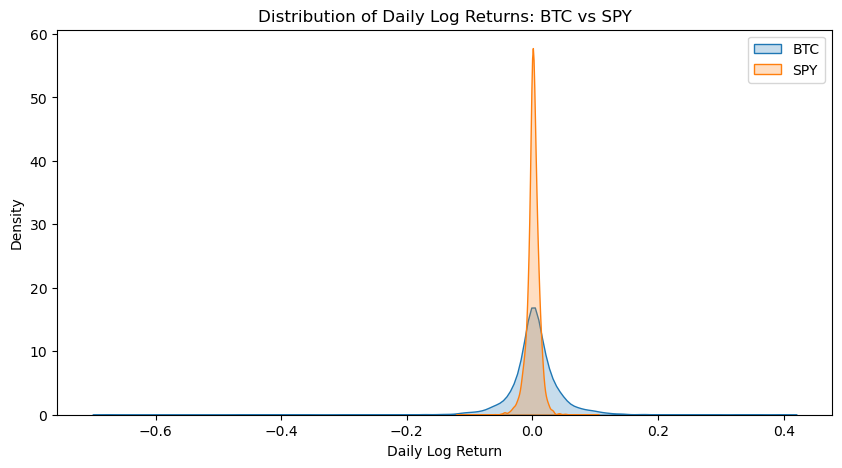

/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:27: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["BTC"], label="BTC", shade=True)
/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["ETH"], label="ETH", shade=True)


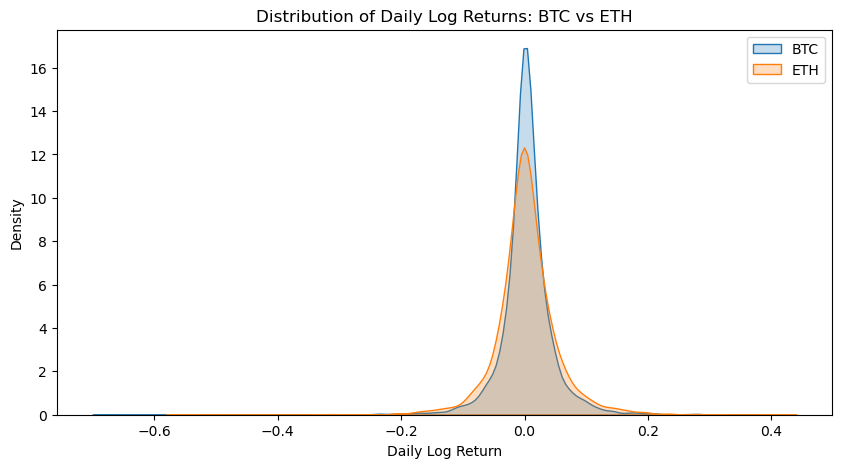

/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["BTC"], label="BTC", shade=True)
/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["XLK"], label="XLK (Tech)", shade=True)
/var/folders/yh/h42_vf9d1_98trjfmzmk6rg00000gn/T/ipykernel_37816/3348024926.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(returns_4a["XLF"], label="XLF (Financials)", shade=True)


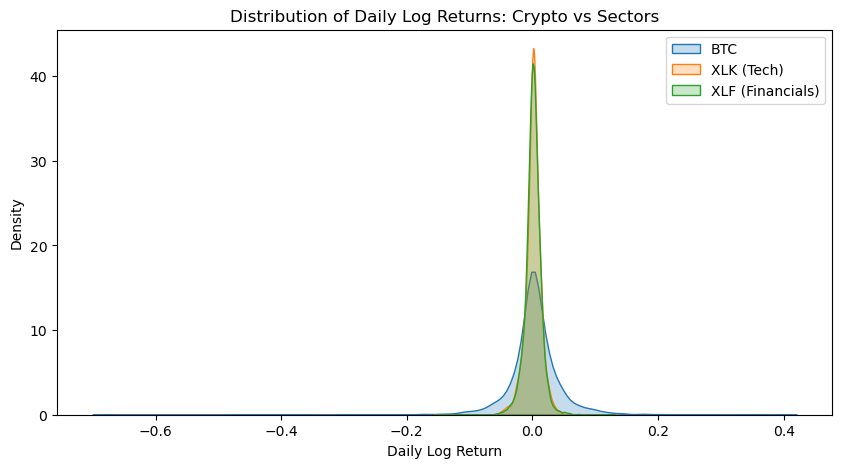

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select assets
assets_4a = {
    "BTC": BTC,
    "ETH": ETH,
    "SPY": SPY,
    "XLK": XLK,
    "XLF": XLF
}

returns_4a = {t: df["log_return"].dropna() for t, df in assets_4a.items()}

# 1. HISTOGRAMS / KDE — BTC vs SPY
plt.figure(figsize=(10,5))
sns.kdeplot(returns_4a["BTC"], label="BTC", shade=True)
sns.kdeplot(returns_4a["SPY"], label="SPY", shade=True)
plt.title("Distribution of Daily Log Returns: BTC vs SPY")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# 2. HISTOGRAMS / KDE — BTC vs ETH
plt.figure(figsize=(10,5))
sns.kdeplot(returns_4a["BTC"], label="BTC", shade=True)
sns.kdeplot(returns_4a["ETH"], label="ETH", shade=True)
plt.title("Distribution of Daily Log Returns: BTC vs ETH")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# 3. BTC vs XLK vs XLF — risk profile compare
plt.figure(figsize=(10,5))
sns.kdeplot(returns_4a["BTC"], label="BTC", shade=True)
sns.kdeplot(returns_4a["XLK"], label="XLK (Tech)", shade=True)
sns.kdeplot(returns_4a["XLF"], label="XLF (Financials)", shade=True)
plt.title("Distribution of Daily Log Returns: Crypto vs Sectors")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()


## Scatterplots 

Correlation matrix (daily log returns):


,BTC,ETH,XRP,SPY,XLK,XLF,XLY,XLP
BTC,1.000000,0.840400,0.630829,0.415660,0.393726,0.337282,0.424063,0.171921
ETH,0.840400,1.000000,0.655499,0.444904,0.424871,0.353169,0.437920,0.180169
XRP,0.630829,0.655499,1.000000,0.327336,0.300381,0.295745,0.327588,0.152007
SPY,0.415660,0.444904,0.327336,1.000000,0.932664,0.826242,0.886894,0.558119
XLK,0.393726,0.424871,0.300381,0.932664,1.000000,0.648347,0.815576,0.371188
XLF,0.337282,0.353169,0.295745,0.826242,0.648347,1.000000,0.710184,0.559848
XLY,0.424063,0.437920,0.327588,0.886894,0.815576,0.710184,1.000000,0.456247
XLP,0.171921,0.180169,0.152007,0.558119,0.371188,0.559848,0.456247,1.000000


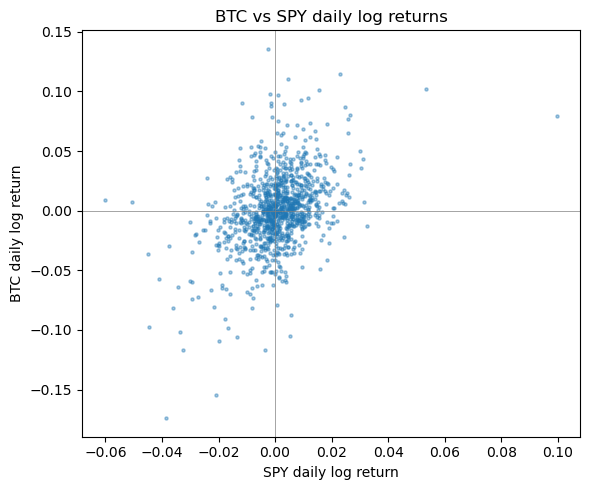

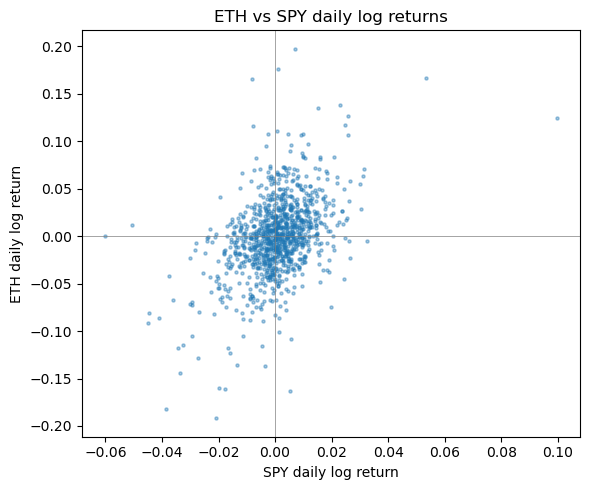

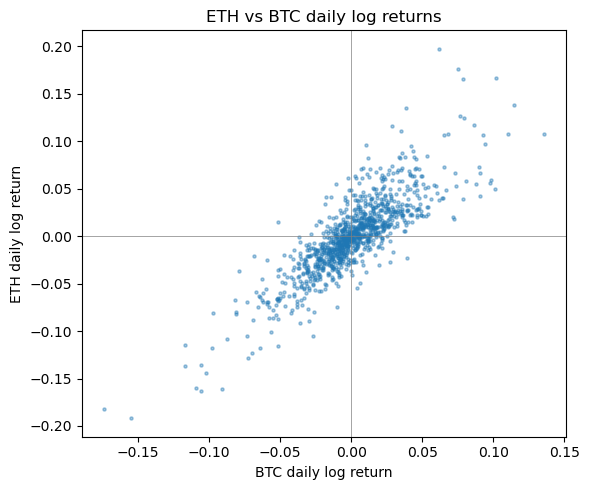

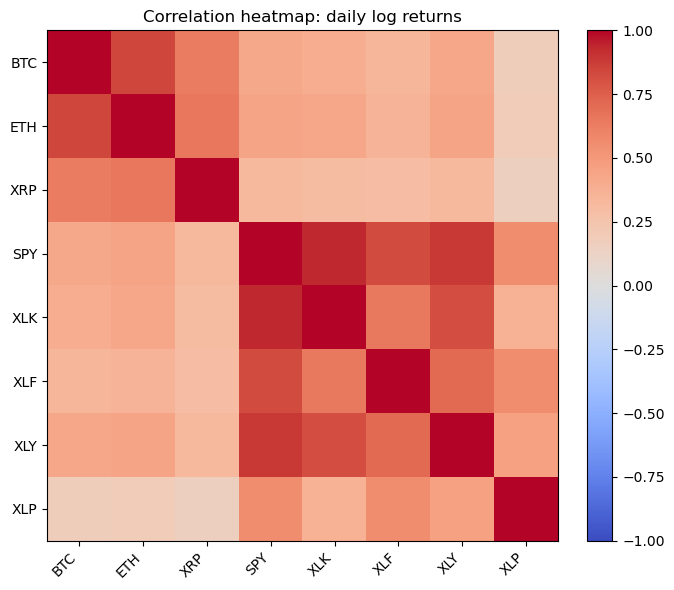

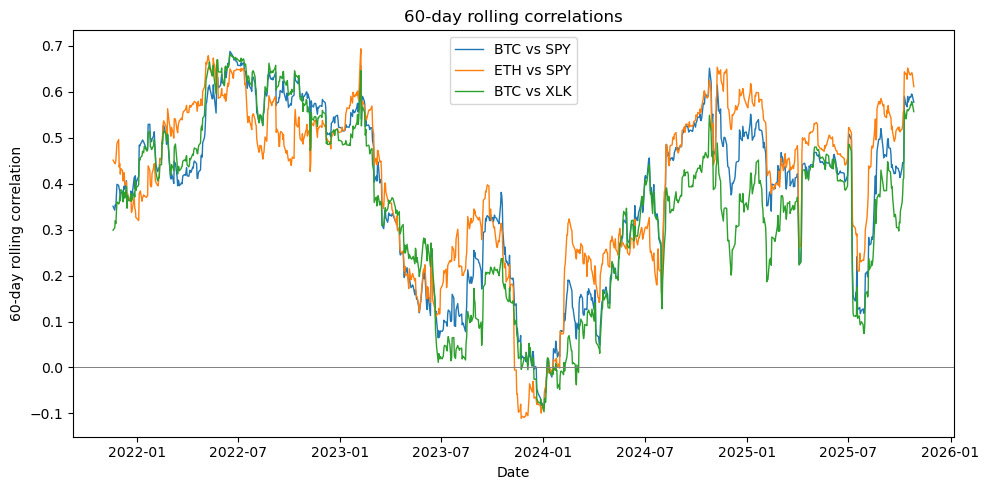

In [46]:
subset_cols = ["BTC", "ETH", "XRP", "SPY", "XLK", "XLF", "XLY", "XLP"]
subset_cols = [c for c in subset_cols if c in combined_returns.columns]

subset = combined_returns[subset_cols].dropna()

# BTC vs SPY
plt.figure(figsize=(6, 5))
plt.scatter(subset["SPY"], subset["BTC"], alpha=0.4, s=5)
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.xlabel("SPY daily log return")
plt.ylabel("BTC daily log return")
plt.title("BTC vs SPY daily log returns")
plt.tight_layout()

# ETH vs SPY
plt.figure(figsize=(6, 5))
plt.scatter(subset["SPY"], subset["ETH"], alpha=0.4, s=5)
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.xlabel("SPY daily log return")
plt.ylabel("ETH daily log return")
plt.title("ETH vs SPY daily log returns")
plt.tight_layout()

# ETH vs BTC
plt.figure(figsize=(6, 5))
plt.scatter(subset["BTC"], subset["ETH"], alpha=0.4, s=5)
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.xlabel("BTC daily log return")
plt.ylabel("ETH daily log return")
plt.title("ETH vs BTC daily log returns")
plt.tight_layout()

# Correlation matrix & heatmap 

corr_mat = subset.corr()
print("Correlation matrix (daily log returns):")
display(corr_mat)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr_mat, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_mat.index)), corr_mat.index)
plt.title("Correlation heatmap: daily log returns")
plt.tight_layout()

# Rolling correlations (60-day)

window = 60

roll_btc_spy = combined_returns["BTC"].rolling(window).corr(combined_returns["SPY"])
roll_eth_spy = combined_returns["ETH"].rolling(window).corr(combined_returns["SPY"])
roll_btc_xlk = combined_returns["BTC"].rolling(window).corr(combined_returns["XLK"])

plt.figure(figsize=(10, 5))
plt.plot(roll_btc_spy.index, roll_btc_spy, label="BTC vs SPY", linewidth=1)
plt.plot(roll_eth_spy.index, roll_eth_spy, label="ETH vs SPY", linewidth=1)
plt.plot(roll_btc_xlk.index, roll_btc_xlk, label="BTC vs XLK", linewidth=1)
plt.axhline(0, color="grey", linewidth=0.7)
plt.xlabel("Date")
plt.ylabel(f"{window}-day rolling correlation")
plt.title(f"{window}-day rolling correlations")
plt.legend()
plt.tight_layout()

In [47]:
# 1. Define Up/Down categories
combined_returns["BTC_up"] = combined_returns["BTC"] > 0
combined_returns["SPY_up"] = combined_returns["SPY"] > 0
combined_returns["ETH_up"] = combined_returns["ETH"] > 0  # optional for crypto-cross

# 2. SPY vs BTC direction crosstab
crosstab_spy_btc = pd.crosstab(
    combined_returns["SPY_up"],
    combined_returns["BTC_up"]
)
crosstab_spy_btc.index = ["SPY_down", "SPY_up"]
crosstab_spy_btc.columns = ["BTC_down", "BTC_up"]

# 3. Percentage version
crosstab_spy_btc_pct = crosstab_spy_btc.div(crosstab_spy_btc.sum(axis=1), axis=0).round(3)

print("=== SPY vs BTC Crosstab (Counts) ===")
display(crosstab_spy_btc)

print("=== SPY vs BTC Crosstab (Percentages) ===")
display(crosstab_spy_btc_pct)

# 4. BTC vs ETH direction crosstab
crosstab_btc_eth = pd.crosstab(
    combined_returns["BTC_up"],
    combined_returns["ETH_up"]
)
crosstab_btc_eth.index = ["BTC_down", "BTC_up"]
crosstab_btc_eth.columns = ["ETH_down", "ETH_up"]

crosstab_btc_eth_pct = crosstab_btc_eth.div(crosstab_btc_eth.sum(axis=1), axis=0).round(3)

print("=== BTC vs ETH Crosstab (Counts) ===")
display(crosstab_btc_eth)

print("=== BTC vs ETH Crosstab (Percentages) ===")
display(crosstab_btc_eth_pct)


=== SPY vs BTC Crosstab (Counts) ===


,BTC_down,BTC_up
SPY_down,318,164
SPY_up,214,350


=== SPY vs BTC Crosstab (Percentages) ===


,BTC_down,BTC_up
SPY_down,0.660,0.340
SPY_up,0.379,0.621


=== BTC vs ETH Crosstab (Counts) ===


,ETH_down,ETH_up
BTC_down,444,88
BTC_up,89,425


=== BTC vs ETH Crosstab (Percentages) ===


,ETH_down,ETH_up
BTC_down,0.835,0.165
BTC_up,0.173,0.827


The visualizations provide clear evidence about how crypto assets behave in relation to the U.S. stock market and its major sectors.

Crypto assets remain substantially more volatile than equities. This is visible in the return distributions and the wide range of motion in the line charts. Even during the same time window, crypto price swings are far larger and more frequent than movements in SPY or the sector ETFs.

Crypto tends to move with the stock market, but not perfectly. The scatterplots for BTC vs SPY and ETH vs SPY show a positive slope, meaning the assets often rise and fall together. However, the points are widely spread, confirming that the relationship is noisy and inconsistent on a day-to-day basis.

Crypto assets are strongly related to each other. BTC and ETH show tight positive clustering in their scatterplot, and the correlation heatmap indicates that most popular cryptocurrencies co-move to a high degree. This supports the idea that BTC acts as a “reference asset” for the rest of the crypto market.

Sector relationships vary. Technology (XLK) moves more closely with BTC, while defensive sectors like XLP or XLU show very weak associations. This suggests that correlations between crypto and equities are strongest when the equity market itself is in a risk-on environment.

## Part 3: Inference

**Research Question**: Do major cryptocurrencies (BTC, ETH, XRP, SOL) behave more like a traditional financial asset/commodity (represented by the Financial Sector XLF) or a speculative asset (represented by XLK?

Null Hypothesis: Crypto price movements have no significant linear relationship with either the Technology (XLK) or Financial (XLF) sectors.

Alternative Hypothesis: Crypto returns will exhibit a statistically significant correlation with the Technology sector (XLK), suggesting it currently functions as a "risk-on" asset rather than a hedge.

Historically, crypto was created as an alternative to the traditional banking system, which implies it should theoretically perform inversely with traditionalfinance. However, as crypto gains popularity has grown, crypto is increasingly treated by Wall Street as a high-growth play. If this narrative is true, we should see XLK predicting cryptocurrencies moves much more accurately than XLF.

To test the hypothesis that cryptocurrency returns are driven by specific traditional market sectors, I will utilize a Multiple Linear Regression model. This allows me to isolate the individual impact of the Technology sector (XLK) and the Financial sector (XLF) on cryptocurrency prices while controlling for the other.

Coin  | Tech Beta (XLK) | P-Value    | Fin Beta (XLF)  | P-Value    | R-Squared 
-------------------------------------------------------------------------------------
BTC   | 0.5861          | 0.0000     | 0.3644          | 0.0002     | 0.1662
ETH   | 0.8585          | 0.0000     | 0.4522          | 0.0003     | 0.1905
XRP   | 0.5463          | 0.0000     | 0.6708          | 0.0000     | 0.1072
SOL   | 0.9972          | 0.0000     | 0.5462          | 0.0022     | 0.1370


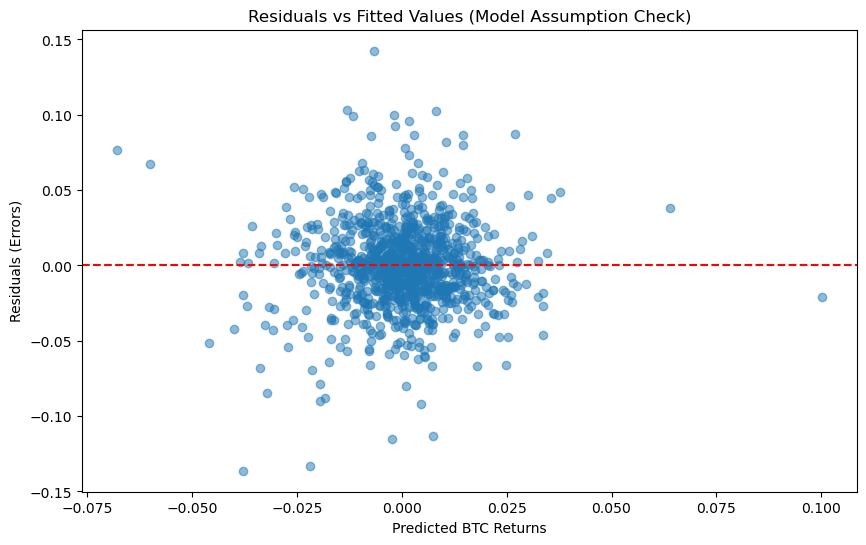

In [51]:
clean_data = combined_returns.dropna()

X = clean_data[['XLK', 'XLF']]
X = sm.add_constant(X)

coins_to_test = ['BTC', 'ETH', 'XRP', 'SOL'] 

print(f"{'Coin':<5} | {'Tech Beta (XLK)':<15} | {'P-Value':<10} | {'Fin Beta (XLF)':<15} | {'P-Value':<10} | {'R-Squared':<10}")
print("-" * 85)

for coin in coins_to_test:
    if coin in clean_data.columns:
        y = clean_data[coin]
        
        #Fit the OLS model
        model = sm.OLS(y, X).fit()
        
        #metrics
        tech_beta = model.params['XLK']
        tech_p = model.pvalues['XLK']
        fin_beta = model.params['XLF']
        fin_p = model.pvalues['XLF']
        r_squared = model.rsquared
        
        print(f"{coin:<5} | {tech_beta:.4f}          | {tech_p:.4f}     | {fin_beta:.4f}          | {fin_p:.4f}     | {r_squared:.4f}")

        if coin == 'BTC':
            btc_model = model

#Homoscedacity check
residuals = btc_model.resid
fitted_vals = btc_model.fittedvalues

plt.figure(figsize=(10,6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values (Model Assumption Check)')
plt.xlabel('Predicted BTC Returns')
plt.ylabel('Residuals (Errors)')
plt.show()

**Evaluation**

For the p-Values across all four cryptocurrencies tested, the p-values for both the Technology (XLK) and Financial (XLF) sectors were 0.0000 (or very close to it). Therefore, We can reject the Null Hypothesis with >99% confidence. There is virtually zero probability that the relationship we observed between traditional stock sectors and crypto prices happened by random chance. 

Both Tech and Financial sectors are statistically significant predictors of crypto returns.

The Beta coefficients reveal information for each coin: SOL had the highest sensitivity to the Tech sector (beta = 0.9972).

Bitcoin is more independent, as BTC showed the lowest Beta to the Tech sector (beta = 0.5861). While it still follows Tech, it is significantly less reactive than SOL or ETH, supporting its status as a relatively more stable "market leader.

XRP was the only cryptocurrency where the Financial Sector Beta (beta = 0.67) was higher than the Tech Sector Beta (beta = 0.54). While the rest of the market chases Tech stocks, XRP is more heavily influenced by the banking sector.

The residuals vs. fitted values plot shows a random distribution of errors around zero. This suggests that homoscedasticity is met, and the linear model is appropriate for this data.

**Potential Bias**

1. Potential for Selection Bias: We selected four cryptocurrencies (BTC, ETH, XRP, SOL) to represent the market. This selection introduces survivorship bias. We are analyzing assets that are currently successful and have high liquidity. This sample does not account for the hundreds of cryptocurrencies that failed or lost correlation with the market during the same period. Therefore, our conclusion that "Crypto follows Tech" mainly applies to established assets, not necessarily small-cap assets, that might exhibit different, uncorrelated behaviors.

2. Correlation vs. Causality: We observed a strong statistical relationship between Tech stocks (XLK) and Crypto. However, this does not prove that Tech stocks cause Crypto to move. It is possible that a third variable, such as global liquidity drives both simultaneously. When liquidity is abundant, investors buy both Tech and Crypto, when it dries up, they sell both.

**Conclusion**

Going into this project, I wanted to test if crypto acts as a hedge against the traditional system. My analysis suggests the opposite. Based on my regression results, I have to reject the Null Hypothesis. It is clear to me that crypto prices are not independent, they are deeply intertwined with the traditional stock market.

The most interesting part of this analysis was XRP. It was the only coin in that cared more about the Financial sector (XLF) than the Tech sector (XLK). This is a big deal because it proves that the crypto market isn't just one big block moving together. Investors actually seem to understand that XRP is a "banking coin" and price it accordingly.

Ultimately, while Bitcoin is often marketed as a separate asset class that stands apart from the financial system, my model shows that at least mathematically, it currently behaves like a volatile version of a tech stock. The data suggests that we are starting to see "sectors" emerge within crypto (like Utility vs. Banking), but the entire asset class is still very much tethered to traditional equity markets.

## Prediction

For my prediction, I want to be able to predict the next days log return of bitcoin. Since bitcoin is a market leader in crypto, it would allow us to predict trends in the broader crypto market.

Since this is time-series data, I will use an 80/20 Split:

Training Data: The first 80% of the timeline.

Test Data: The final 20% of the timeline (the "unseen" future).

Model Selection: 

I will be selecting a linear regression model as a basline model. A linear regression model is low variance and simple.

Evaluation of Models: I will evaluate the models using RMSE (Root Mean Squared Error).

Training Samples: 835 | Test Samples: 209
----------------------------------------
Linear Regression RMSE: 0.02310
----------------------------------------


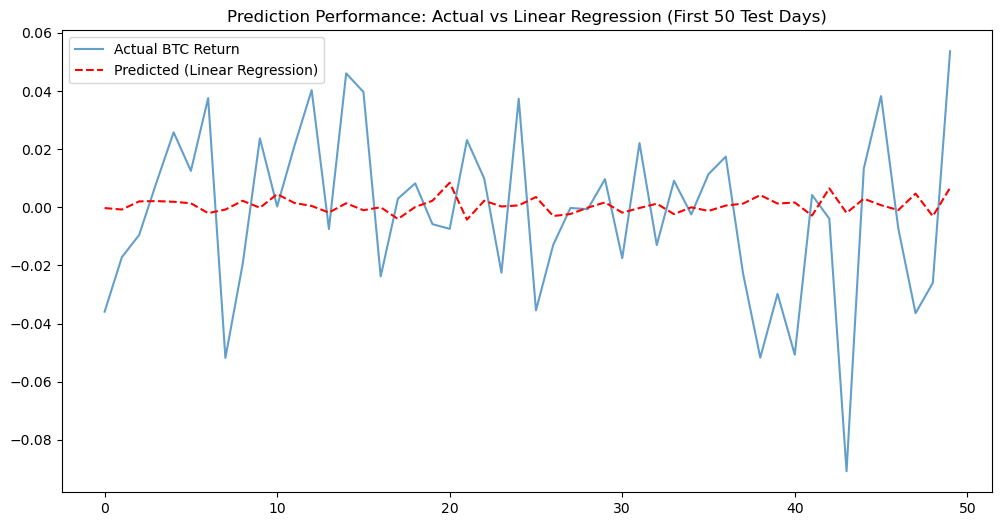

In [62]:
df_pred = combined_returns.copy()

#Predictors: Today's returns
#Target: Tomorrow's BTC return
df_pred['Target_Next_Day_BTC'] = df_pred['BTC'].shift(-1)

df_pred = df_pred.dropna()

features = ['BTC', 'XLK', 'XLF'] # Using today's returns to predict tomorrow
X = df_pred[features]
y = df_pred['Target_Next_Day_BTC']

#Train and test splits
split_point = int(len(df_pred) * 0.8) # 80% Train, 20% Test

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Training Samples: {len(X_train)} | Test Samples: {len(X_test)}")

#Model fitting

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

#Evaluation
print("-" * 40)
print(f"Linear Regression RMSE: {lr_rmse:.5f}")
print("-" * 40)

plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual BTC Return', alpha=0.7)
plt.plot(lr_pred[:50], label='Predicted (Linear Regression)', color='red', linestyle='--')
plt.title('Prediction Performance: Actual vs Linear Regression (First 50 Test Days)')
plt.legend()
plt.show()

As seen in the plot above, the Linear Regression model "under-fit" the volatility. It essentially predicted a near-zero return for every day (the mean). This is a known phenomenon in financial modeling: because market noise is high, a linear model minimizes error by "playing it safe" and ignoring the spikes. While this results in a stable RMSE, it fails to capture the "high highs and low lows" that are critical for risk management.

After doing some model research, I have chosen XGBoost (Extreme Gradient Boosting) as our final predictive framework. Unlike Random Forest, which builds independent trees and averages their predictions, XGBoost builds trees sequentially, where each new tree is specifically trained to correct the residuals of the previous one. This forces the model to focus its attention on the "hard-to-predict" outliers, specifically the sudden price spikes and drops that linear models ignore.

XGBoost RMSE: 0.03653


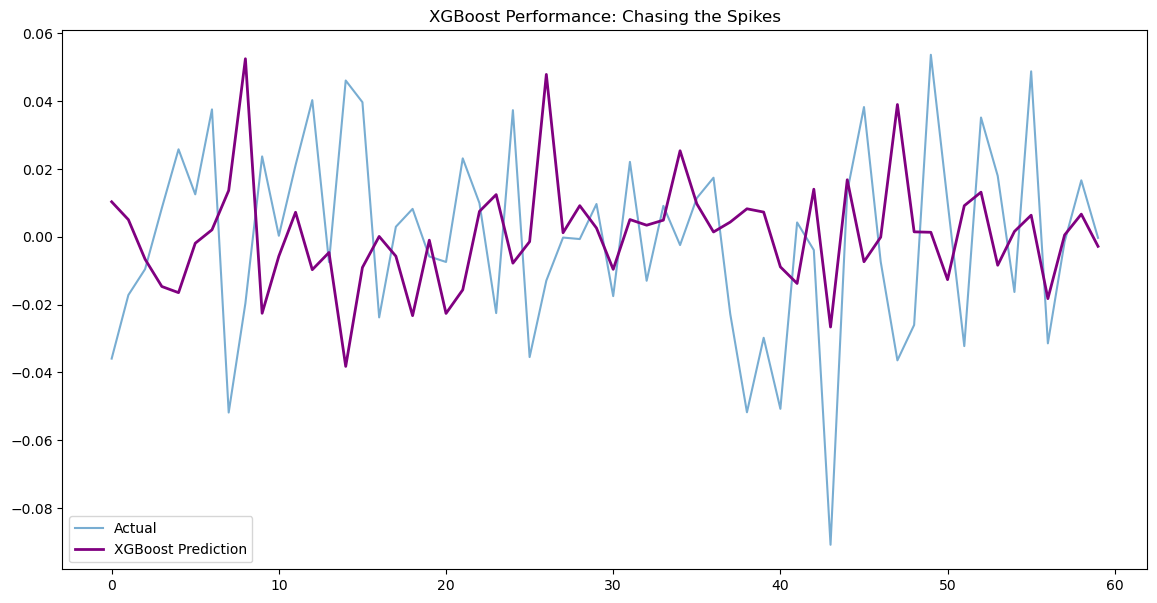

In [49]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Training
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             learning_rate=0.15, 
                             max_depth=5, 
                             random_state=42)

model_xgb.fit(X_train_h, y_train_h)
pred_xgb = model_xgb.predict(X_test_h)

#Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test_h, pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb:.5f}")

plt.figure(figsize=(14, 7))
plt.plot(range(60), y_test_h.values[:60], label='Actual', color='#1f77b4', alpha=0.6)
plt.plot(range(60), pred_xgb[:60], label='XGBoost Prediction', color='purple', linewidth=2)
plt.title('XGBoost Performance: Chasing the Spikes')
plt.legend()
plt.show()

As you can see from the plot above, the XGBoost model is predicting the volatility much better than the Linear regression model, but results in a lower RMSE due to predicting the volatility the wrong way in some cases. Although this may look worse statistically on paper, I do believe this is a step in the right direction.

## Final thoughts and conclusion

**Evaluation of Utility**

Is the model useful for trading? No. Because the model frequently predicts the wrong direction during volatile periods, using it to blindly go Long or Short would likely result in losses. It is not properly tuned to predict market direction.

For Risk Management? Yes. The model is highly useful as a volatility scanner. Even when the direction is wrong, the magnitude of the prediction is informative. If the XGBoost model predicts a large move (either positive or negative), a Risk Manager should interpret this as a signal that the market is becoming volatile.

Instead of trading the direction, the optimal strategy would be to reduce leverage or widen stop-losses whenever the model predicts a nonzero value, regardless of the sign.

**Future Work** 

To fix the directional inaccuracy while keeping the volatility sensitivity, I would introduce Sentiment Analysis.

Our current model knows something big is happening, but it doesn't know if it's "Panic Selling" or "FOMO Buying."

By adding a feature that scrapes internet sentiment, we could provide the direction to the predicted volatility. we have already successfully modeled.

I also think increasing our train/test sets would definitely help. Luckily there is more data being produced on this every day, so our sets will continue to grow too.